## The forward and backward passes

In [13]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np
from pathlib import Path
from torch import tensor
from fastcore.test import test_close
torch.manual_seed(42)

mpl.rcParams['image.cmap'] = 'gray'
torch.set_printoptions(precision=2, linewidth=125, sci_mode=False)
np.set_printoptions(precision=2, linewidth=125)

path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

## Foundations version

### Basic architecture

In [7]:
n,m = x_train.shape
c = y_train.max()+1
n,m,c

(50000, 784, tensor(10))

In [8]:
# num hidden
nh = 50

In [10]:
w1 = torch.randn(m,nh)
b1 = torch.zeros(nh)
w2 = torch.randn(nh,1)
b2 = torch.zeros(1)
w1.shape, b1.shape, w2.shape, b2.shape

(torch.Size([784, 50]), torch.Size([50]), torch.Size([50, 1]), torch.Size([1]))

In [11]:
def lin(x, w, b): return x@w + b

In [12]:
t = lin(x_valid, w1, b1)
t.shape

torch.Size([10000, 50])

In [14]:
def relu(x): return x.clamp_min(0.)

In [15]:
t = relu(t)
t

tensor([[ 0.00,  0.00,  0.00,  ...,  4.04,  0.00,  0.00],
        [ 3.56,  0.00,  0.00,  ...,  0.88,  3.10,  0.00],
        [ 6.66,  4.48,  0.00,  ...,  5.81,  8.84,  3.07],
        ...,
        [16.45,  0.00,  0.00,  ..., 11.17,  0.00,  0.00],
        [ 7.03,  0.51,  0.00,  ...,  8.39,  0.00,  3.69],
        [10.94,  0.00,  0.00,  ...,  0.00,  0.00, 11.96]])

In [20]:
def model(xb):
    print(xb.shape, w1.shape, b1.shape)
    l1 = lin(xb, w1, b1)
    print(l1.shape)
    l2 = relu(l1)
    print(l2.shape, w2.shape, b2.shape)
    return lin(l2, w2, b2)

In [21]:
res = model(x_valid)
res.shape

torch.Size([10000, 784]) torch.Size([784, 50]) torch.Size([50])
torch.Size([10000, 50])
torch.Size([10000, 50]) torch.Size([50, 1]) torch.Size([1])


torch.Size([10000, 1])

### Loss function: MSE

(Of course, `mse` is not a suitable loss function for multi-class classification; we'll use a better loss function soon. We'll use `mse` for now to keep things simple.)

In [22]:
res.shape,y_valid.shape

(torch.Size([10000, 1]), torch.Size([10000]))

In [23]:
(res-y_valid).shape

torch.Size([10000, 10000])

We need to get rid of that trailing (,1), in order to use `mse`.

In [24]:
res[:,0].shape

torch.Size([10000])

In [25]:
res.squeeze().shape

torch.Size([10000])

In [26]:
(res[:,0]-y_valid).shape

torch.Size([10000])

In [27]:
y_train,y_valid = y_train.float(),y_valid.float()

preds = model(x_train)
preds.shape

torch.Size([50000, 784]) torch.Size([784, 50]) torch.Size([50])
torch.Size([50000, 50])
torch.Size([50000, 50]) torch.Size([50, 1]) torch.Size([1])


torch.Size([50000, 1])

In [28]:
def mse(output, targ): return (output[:,0]-targ).pow(2).mean()

In [30]:
mse(preds, y_train)

tensor(1549.37)

### Gradients and backward pass

In [31]:
from sympy import symbols,diff
x,y = symbols('x y')
diff(x**2, x)

2*x

In [32]:
diff(3*x**2+9, x)

6*x

### 为什么 ∂out/∂inp = wᵀ？——从标量展开理解矩阵求导

线性层的前向计算：`out = inp @ w + b`

**先看单个样本（去掉 batch 维度）**，设 inp 有 3 个元素，w 是 3×2 矩阵：

$$
\text{inp} = [x_1, x_2, x_3], \quad
w = \begin{bmatrix} w_{11} & w_{12} \\ w_{21} & w_{22} \\ w_{31} & w_{32} \end{bmatrix}
$$

那么 out 的每个元素是 inp 和 w 对应列的点积：

$$
\text{out}_1 = x_1 w_{11} + x_2 w_{21} + x_3 w_{31} \\
\text{out}_2 = x_1 w_{12} + x_2 w_{22} + x_3 w_{32}
$$

**现在对 inp 求偏导**。以 $x_2$ 为例，逐项求导：

$$
\frac{\partial \text{out}_1}{\partial x_2}
= \frac{\partial (x_1 w_{11} + x_2 w_{21} + x_3 w_{31})}{\partial x_2}
= w_{21}
$$

$$
\frac{\partial \text{out}_2}{\partial x_2}
= \frac{\partial (x_1 w_{12} + x_2 w_{22} + x_3 w_{32})}{\partial x_2}
= w_{22}
$$

（因为 $x_1, x_3$ 对于 $\frac{\partial}{\partial x_2}$ 而言是常数，导数为 0；$x_2$ 的系数就是对应的 $w$ 值。）

用链式法则求 Loss 对 $x_2$ 的梯度：

$$
\frac{\partial L}{\partial x_2}
= \frac{\partial L}{\partial \text{out}_1} \cdot \frac{\partial \text{out}_1}{\partial x_2}
+ \frac{\partial L}{\partial \text{out}_2} \cdot \frac{\partial \text{out}_2}{\partial x_2}
= \frac{\partial L}{\partial \text{out}_1} \cdot w_{21}
+ \frac{\partial L}{\partial \text{out}_2} \cdot w_{22}
= \text{out.g} \cdot \begin{bmatrix} w_{21} \\ w_{22} \end{bmatrix}
$$

注意 $[w_{21}, w_{22}]$ 正好是 **w 的第 2 行**，也就是 **wᵀ 的第 2 列**。

**同理对 $x_1$ 和 $x_3$**：

$$
\frac{\partial L}{\partial x_1}
= \frac{\partial L}{\partial \text{out}_1} \cdot \frac{\partial \text{out}_1}{\partial x_1}
+ \frac{\partial L}{\partial \text{out}_2} \cdot \frac{\partial \text{out}_2}{\partial x_1}
= \frac{\partial L}{\partial \text{out}_1} \cdot w_{11}
+ \frac{\partial L}{\partial \text{out}_2} \cdot w_{12}
= \text{out.g} \cdot \begin{bmatrix} w_{11} \\ w_{12} \end{bmatrix}
\quad \leftarrow \text{w 的第 1 行}
$$

$$
\frac{\partial L}{\partial x_3}
= \frac{\partial L}{\partial \text{out}_1} \cdot \frac{\partial \text{out}_1}{\partial x_3}
+ \frac{\partial L}{\partial \text{out}_2} \cdot \frac{\partial \text{out}_2}{\partial x_3}
= \frac{\partial L}{\partial \text{out}_1} \cdot w_{31}
+ \frac{\partial L}{\partial \text{out}_2} \cdot w_{32}
= \text{out.g} \cdot \begin{bmatrix} w_{31} \\ w_{32} \end{bmatrix}
\quad \leftarrow \text{w 的第 3 行}
$$

**规律已经清晰**：$\frac{\partial L}{\partial x_k}$ 都是 out.g 点乘 **w 的第 k 行**。把三个结果拼成一行向量：

$$
\text{inp.g} = \left[\frac{\partial L}{\partial x_1}, \frac{\partial L}{\partial x_2}, \frac{\partial L}{\partial x_3}\right]
= \text{out.g} \; @ \;
\begin{bmatrix} w_{11} & w_{21} & w_{31} \\ w_{12} & w_{22} & w_{32} \end{bmatrix}
= \text{out.g} \; @ \; w^T
$$

> **直觉**：前向时 `inp @ w` 把 inp 沿着 w 的列方向「投影」出去；反向时 `out.g @ wᵀ` 把梯度沿着 w 的行方向「投影回来」。wᵀ 的作用就是**把信息从输出空间映射回输入空间**。

**加上 batch 维度后形状验证**：
- `out.g`: [batch, out_dim]
- `w.t()`: [out_dim, in_dim]
- 结果 `inp.g`: [batch, in_dim] ✓ 和 inp 形状一致

### 证明：`inp.T @ out.g` 与 `Σ (inp[i] ⊗ out.g[i])` 等价

`lin_grad` 中计算 ∂Loss/∂w 有两种写法，它们是**完全等价**的：

| 写法 | 代码 | 思路 |
|------|------|------|
| **矩阵乘法** | `inp.t() @ out.g` | 一步到位，高效 |
| **外积求和** | `(inp.unsqueeze(-1) * out.g.unsqueeze(1)).sum(0)` | 逐样本理解，直觉清晰 |

**为什么等价？** 把矩阵乘法展开到元素级别：

$$
(\text{inp}^T @ \text{out.g})_{j,k}
= \sum_{i=0}^{B-1} \text{inp}[i,j] \cdot \text{out.g}[i,k]
$$

而外积求和的第 $(j,k)$ 个元素：

$$
\sum_{i=0}^{B-1} \underbrace{(\text{inp}[i] \otimes \text{out.g}[i])}_{外积矩阵}[j,k]
= \sum_{i=0}^{B-1} \text{inp}[i,j] \cdot \text{out.g}[i,k]
$$

**完全相同的求和！** 只是计算顺序不同：
- **矩阵乘法**：先转置再一次性做 batch 内积（GPU 友好）
- **外积求和**：先对每个样本做外积，再沿 batch 累加（概念清晰）

> **注意**：`@` 是**矩阵乘法**（不是逐元素广播）。规则很简单：**前者列数 == 后者行数**。
> 例如 `[3,4] @ [4,2] → [3,2]`，内维度 4 被消掉了。

下面用 **batch=4, in_dim=3, out_dim=2**（三个维度全不同）的小整数张量 **逐步验证**：

In [47]:
# ===== 小整数示例：证明 inp.T @ out.g == Σ(inp[i] ⊗ out.g[i]) =====
# 刻意让 batch=4, in_dim=3, out_dim=2 全部不同，避免维度巧合造成混淆

inp_demo = tensor([[1, 2, 3],     # 样本 0
                   [4, 5, 6],     # 样本 1
                   [1, 0, -1],    # 样本 2
                   [2, 3, 1]])    # 样本 3  → shape: [4, 3]

outg_demo = tensor([[1, -1],      # 样本 0 的输出梯度
                    [2,  0],      # 样本 1
                    [0,  3],      # 样本 2
                    [1,  1]])     # 样本 3  → shape: [4, 2]

print("inp (batch=4, in_dim=3):")
print(inp_demo)
print(f"\nout.g (batch=4, out_dim=2):")
print(outg_demo)

# ---------- 方法 1: 矩阵乘法 ----------
#   inp.T: [3, 4] (in_dim, batch)
#   out.g: [4, 2] (batch, out_dim)
#   矩阵乘法要求: 前者列数 == 后者行数, 即 4 == 4 ✓
#   结果: [3, 2] = [in_dim, out_dim]
result_matmul = inp_demo.t() @ outg_demo
print(f"\n━━━ 方法 1: inp.T @ out.g ━━━")
print(f"  inp.T shape: {list(inp_demo.t().shape)}  (in_dim=3, batch=4)")
print(f"  out.g shape: {list(outg_demo.shape)}  (batch=4, out_dim=2)")
print(f"  矩阵乘法: [3,4] @ [4,2] → 内维度 4==4 匹配 → 结果 [3,2]")
print(f"  结果 shape:  {list(result_matmul.shape)}  (in_dim=3, out_dim=2)")
print(result_matmul)

# ---------- 方法 2: 外积求和 ----------
print(f"\n━━━ 方法 2: 逐样本外积，再沿 batch 求和 ━━━")
for i in range(4):
    outer_i = inp_demo[i].unsqueeze(-1) * outg_demo[i].unsqueeze(0)  # [3,1]*[1,2]→[3,2]
    print(f"  样本 {i}: inp[{i}]={inp_demo[i].tolist()}  ⊗  out.g[{i}]={outg_demo[i].tolist()}")
    print(f"           → 外积 [3,2]:\n{outer_i}")

# 一步广播计算
result_outer = (inp_demo.unsqueeze(-1) * outg_demo.unsqueeze(1)).sum(0)
print(f"\n  四个外积矩阵求和 → [3,2]:")
print(result_outer)

# ---------- 验证 ----------
print(f"\n✅ 两种方法结果相等: {torch.equal(result_matmul, result_outer)}")

inp (batch=4, in_dim=3):
tensor([[ 1,  2,  3],
        [ 4,  5,  6],
        [ 1,  0, -1],
        [ 2,  3,  1]])

out.g (batch=4, out_dim=2):
tensor([[ 1, -1],
        [ 2,  0],
        [ 0,  3],
        [ 1,  1]])

━━━ 方法 1: inp.T @ out.g ━━━
  inp.T shape: [3, 4]  (in_dim=3, batch=4)
  out.g shape: [4, 2]  (batch=4, out_dim=2)
  矩阵乘法: [3,4] @ [4,2] → 内维度 4==4 匹配 → 结果 [3,2]
  结果 shape:  [3, 2]  (in_dim=3, out_dim=2)
tensor([[11,  4],
        [15,  1],
        [16, -5]])

━━━ 方法 2: 逐样本外积，再沿 batch 求和 ━━━
  样本 0: inp[0]=[1, 2, 3]  ⊗  out.g[0]=[1, -1]
           → 外积 [3,2]:
tensor([[ 1, -1],
        [ 2, -2],
        [ 3, -3]])
  样本 1: inp[1]=[4, 5, 6]  ⊗  out.g[1]=[2, 0]
           → 外积 [3,2]:
tensor([[ 8,  0],
        [10,  0],
        [12,  0]])
  样本 2: inp[2]=[1, 0, -1]  ⊗  out.g[2]=[0, 3]
           → 外积 [3,2]:
tensor([[ 0,  3],
        [ 0,  0],
        [ 0, -3]])
  样本 3: inp[3]=[2, 3, 1]  ⊗  out.g[3]=[1, 1]
           → 外积 [3,2]:
tensor([[2, 2],
        [3, 3],
        [1, 1]])

 

/var/folders/k0/nlqc7vt13wd24wjjxks8w4f40000gn/T/ipykernel_28705/2323675789.py:84: UserWarning: Glyph 8855 (\N{CIRCLED TIMES}) missing from font(s) Heiti TC.
  plt.tight_layout()
/Users/bytedance/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8855 (\N{CIRCLED TIMES}) missing from font(s) Heiti TC.
  fig.canvas.print_figure(bytes_io, **kw)


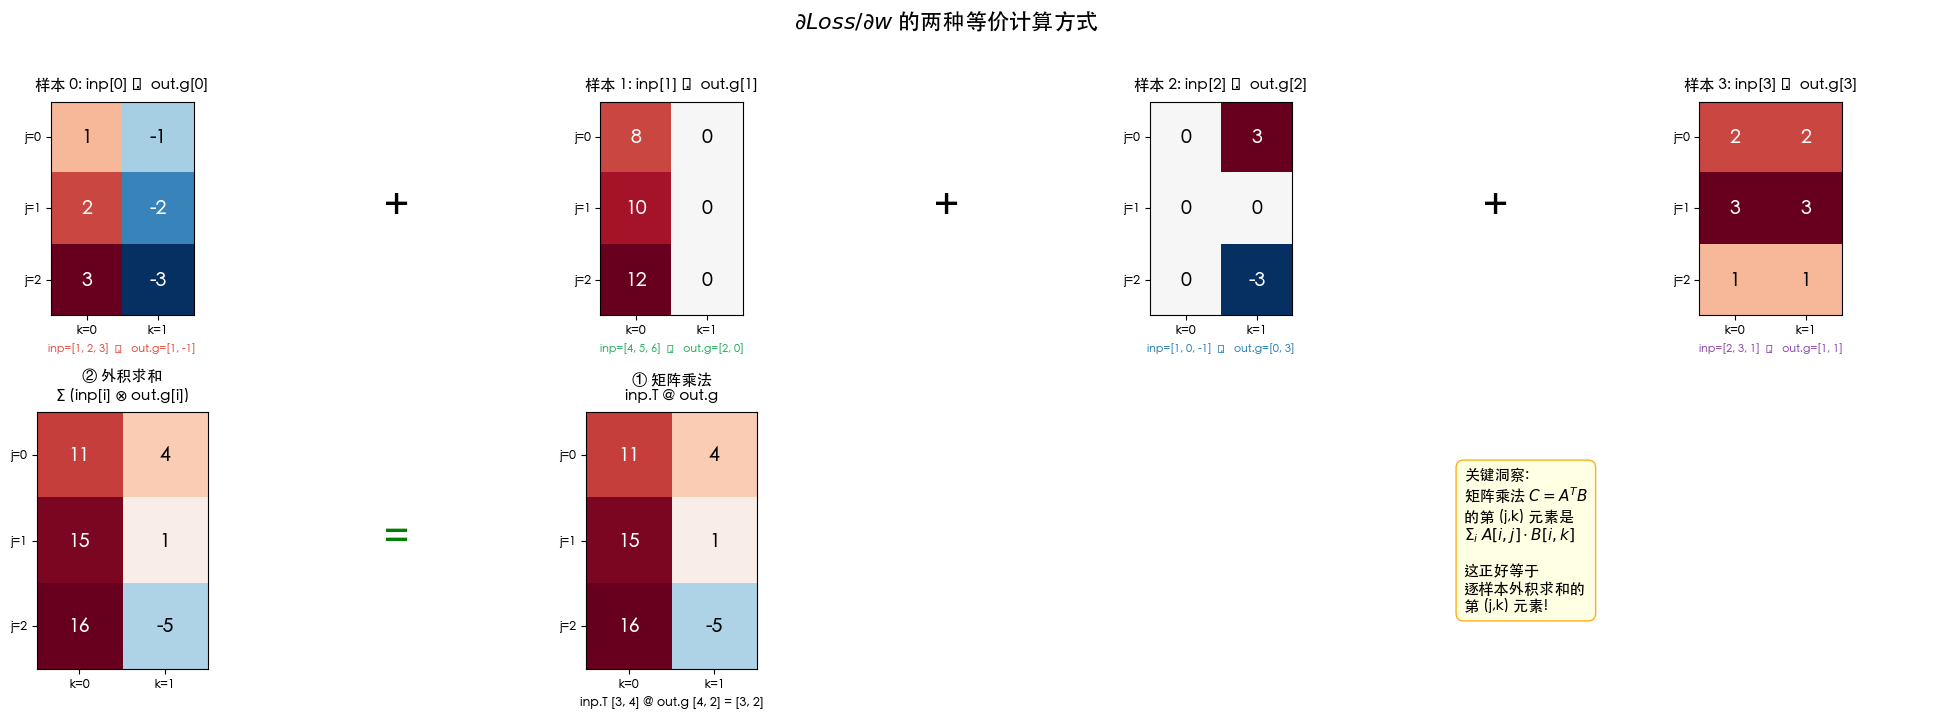

In [48]:
# ===== 可视化：外积求和 == 矩阵乘法 =====
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# --- 中文字体配置 (macOS PingFang SC) ---
plt.rcParams['font.sans-serif'] = ['PingFang SC', 'Heiti TC', 'STHeiti', 'Arial Unicode MS', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False  # 负号正常显示

def draw_matrix(ax, mat, title, row_labels=None, col_labels=None, fontsize=14, cmap='RdBu_r'):
    """在 ax 上画一个带数值标注的矩阵热力图"""
    rows, cols = mat.shape
    vmax = max(abs(mat.min()), abs(mat.max()), 1)
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
    ax.imshow(mat.numpy(), cmap=cmap, norm=norm, aspect='equal')
    for i in range(rows):
        for j in range(cols):
            v = mat[i, j].item()
            color = 'white' if abs(v) > vmax * 0.6 else 'black'
            ax.text(j, i, f'{v:g}', ha='center', va='center', fontsize=fontsize, fontweight='bold', color=color)
    ax.set_title(title, fontsize=11, pad=8)
    ax.set_xticks(range(cols))
    ax.set_yticks(range(rows))
    if col_labels: ax.set_xticklabels(col_labels, fontsize=9)
    else: ax.set_xticklabels([f'k={j}' for j in range(cols)], fontsize=9)
    if row_labels: ax.set_yticklabels(row_labels, fontsize=9)
    else: ax.set_yticklabels([f'j={i}' for i in range(rows)], fontsize=9)

B = inp_demo.shape[0]  # batch=4
outers = [(inp_demo[i].unsqueeze(-1) * outg_demo[i].unsqueeze(0)) for i in range(B)]

fig, axes = plt.subplots(2, 7, figsize=(20, 7),
                         gridspec_kw={'width_ratios': [1, 0.2, 1, 0.2, 1, 0.2, 1],
                                      'height_ratios': [1, 1.2]})

# ---- 第一行：四个外积矩阵 ----
colors_sample = ['#e74c3c', '#27ae60', '#2980b9', '#8e44ad']
for idx in range(B):
    col = idx * 2  # 0, 2, 4, 6
    ax = axes[0, col]
    draw_matrix(ax, outers[idx].float(),
                f'样本 {idx}: inp[{idx}] ⊗ out.g[{idx}]',
                row_labels=[f'j={j}' for j in range(inp_demo.shape[1])],
                col_labels=[f'k={k}' for k in range(outg_demo.shape[1])])
    ax.set_xlabel(f'inp={inp_demo[idx].tolist()}  ⊗  out.g={outg_demo[idx].tolist()}',
                  fontsize=8, color=colors_sample[idx])

# 加号
for col in [1, 3, 5]:
    axes[0, col].axis('off')
    axes[0, col].text(0.5, 0.5, '+', transform=axes[0, col].transAxes,
                      fontsize=30, ha='center', va='center', fontweight='bold')

# ---- 第二行：求和结果 & 矩阵乘法结果 ----
ax_sum = axes[1, 0]
draw_matrix(ax_sum, result_outer.float(), '② 外积求和\n$\\Sigma$ (inp[i] $\\otimes$ out.g[i])', fontsize=14)

axes[1, 1].axis('off')
axes[1, 1].text(0.5, 0.5, '=', transform=axes[1, 1].transAxes,
                fontsize=30, ha='center', va='center', fontweight='bold', color='green')

ax_mat = axes[1, 2]
draw_matrix(ax_mat, result_matmul.float(), '① 矩阵乘法\ninp.T @ out.g', fontsize=14)
ax_mat.set_xlabel(f'inp.T {list(inp_demo.t().shape)} @ out.g {list(outg_demo.shape)} = {list(result_matmul.shape)}',
                  fontsize=9)

# 隐藏多余的 axes
for col in [3, 4, 5, 6]:
    axes[1, col].axis('off')

# 说明文字
axes[1, 5].text(0.0, 0.5,
    '关键洞察:\n'
    '矩阵乘法 $C = A^T B$\n'
    '的第 (j,k) 元素是\n'
    '$\\Sigma_i\\; A[i,j] \\cdot B[i,k]$\n\n'
    '这正好等于\n'
    '逐样本外积求和的\n'
    '第 (j,k) 元素!',
    transform=axes[1, 5].transAxes,
    fontsize=11, va='center',
    bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', edgecolor='orange', alpha=0.9))

fig.suptitle('$\\partial Loss / \\partial w$ 的两种等价计算方式', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [50]:
def lin_grad(inp, out, w, b):
    """线性层 out = inp @ w + b 的反向传播，计算 inp/w/b 三个梯度"""
    # ∂Loss/∂inp = ∂Loss/∂out × ∂out/∂inp = out.g @ w^T
    #   out.g: [batch, out_dim],  w.t(): [out_dim, in_dim]
    #   结果: [batch, in_dim] —— 梯度传回给上一层
    inp.g = out.g @ w.t()

    # ∂Loss/∂w = inp^T @ ∂Loss/∂out
    #   等价写法：对每个样本做外积 inp[i] ⊗ out.g[i]，然后沿 batch 求和
    #   inp.unsqueeze(-1): [batch, in_dim, 1],  out.g.unsqueeze(1): [batch, 1, out_dim]
    #   广播相乘: [batch, in_dim, out_dim]，sum(0) 沿 batch 求和 → [in_dim, out_dim]
    w.g = (inp.unsqueeze(-1) * out.g.unsqueeze(1)).sum(0)

    # ∂Loss/∂b = ∂Loss/∂out 沿 batch 维度求和
    #   因为 b 被广播加到每个样本上，所以梯度是所有样本梯度之和
    b.g = out.g.sum(0)

In [51]:
def forward_and_backward(inp, targ):
    """
    手动实现完整的正向传播 + 反向传播
    网络结构: inp → lin1(w1,b1) → relu → lin2(w2,b2) → out → MSE Loss
    """
    # ============================================================
    # 正向传播：从左到右，逐层计算
    # ============================================================

    # 第1层：线性变换  l1 = inp @ w1 + b1
    #   inp: [50000, 784] × w1: [784, 50] + b1: [50] → l1: [50000, 50]
    l1 = lin(inp, w1, b1)
    print(f"正向 ① 线性层1:  inp {list(inp.shape)} @ w1 {list(w1.shape)} + b1 → l1 {list(l1.shape)}")

    # 第2层：ReLU 激活  l2 = max(0, l1)
    #   把所有负值变为 0，形状不变: [50000, 50]
    l2 = relu(l1)
    n_zero = (l2 == 0).sum().item()
    n_total = l2.numel()
    print(f"正向 ② ReLU:      l1 → l2 {list(l2.shape)}  (被置零的元素: {n_zero}/{n_total} = {n_zero/n_total:.1%})")

    # 第3层：线性变换  out = l2 @ w2 + b2
    #   l2: [50000, 50] × w2: [50, 1] + b2: [1] → out: [50000, 1]
    out = lin(l2, w2, b2)
    print(f"正向 ③ 线性层2:  l2 {list(l2.shape)} @ w2 {list(w2.shape)} + b2 → out {list(out.shape)}")

    # 计算损失：MSE = mean((prediction - target)²)
    #   out[:,0]: [50000] — 去掉多余的维度1, 和 targ 对齐
    diff = out[:,0] - targ
    loss = diff.pow(2).mean()
    print(f"正向 ④ MSE Loss:  mean((out - targ)²) = {loss.item():.2f}")
    print()

    # ============================================================
    # 反向传播：从右到左，用链式法则逐层计算梯度
    # 每个变量的 .g 属性存储 ∂Loss/∂该变量
    # ============================================================

    # ④ Loss 对 out 的梯度: ∂Loss/∂out
    #   Loss = mean(diff²) = sum(diff²) / n
    #   ∂Loss/∂out = 2 * diff / n
    #   diff[:,None]: [50000] → [50000,1]，恢复和 out 相同的形状
    out.g = 2.*diff[:,None] / diff.shape[0]
    print(f"反向 ④ ∂Loss/∂out:  shape={list(out.g.shape)}, 均值={out.g.mean().item():.4f}, 范围=[{out.g.min().item():.2f}, {out.g.max().item():.2f}]")

    # ③ 通过第2层线性层反向传播: 已知 out.g，求 l2.g, w2.g, b2.g
    #   out = l2 @ w2 + b2, 所以:
    #   ∂Loss/∂l2 = out.g @ w2^T       (梯度继续向前传)
    #   ∂Loss/∂w2 = l2^T @ out.g       (用于更新 w2)
    #   ∂Loss/∂b2 = sum(out.g)          (用于更新 b2)
    lin_grad(l2, out, w2, b2)
    print(f"反向 ③ lin_grad(l2→out, w2, b2):")
    print(f"         ∂Loss/∂l2: {list(l2.g.shape)}, ∂Loss/∂w2: {list(w2.g.shape)}, ∂Loss/∂b2: {list(b2.g.shape)}")

    # ② 通过 ReLU 反向传播: 已知 l2.g，求 l1.g
    #   ReLU(x) 的导数: x>0 时为 1，x≤0 时为 0
    #   链式法则: ∂Loss/∂l1 = ∂ReLU/∂l1 * ∂Loss/∂l2
    #   即: 把 l2.g 中对应 l1≤0 位置的梯度「关掉」(乘以0)
    l1.g = (l1>0).float() * l2.g
    n_blocked = (l1 <= 0).sum().item()
    print(f"反向 ② ReLU 梯度:  ∂Loss/∂l1 {list(l1.g.shape)} — {n_blocked} 个梯度被 ReLU 阻断（l1≤0 的位置）")

    # ① 通过第1层线性层反向传播: 已知 l1.g，求 inp.g, w1.g, b1.g
    lin_grad(inp, l1, w1, b1)
    print(f"反向 ① lin_grad(inp→l1, w1, b1):")
    print(f"         ∂Loss/∂inp: {list(inp.g.shape)}, ∂Loss/∂w1: {list(w1.g.shape)}, ∂Loss/∂b1: {list(b1.g.shape)}")
    print()
    print(f"✅ 反向传播完成！所有参数的梯度已计算: w1.g, b1.g, w2.g, b2.g")
    print(f"   w1.g 范围: [{w1.g.min().item():.2f}, {w1.g.max().item():.2f}]")
    print(f"   w2.g 范围: [{w2.g.min().item():.2f}, {w2.g.max().item():.2f}]")

In [52]:
forward_and_backward(x_train, y_train)

正向 ① 线性层1:  inp [50000, 784] @ w1 [784, 50] + b1 → l1 [50000, 50]
正向 ② ReLU:      l1 → l2 [50000, 50]  (被置零的元素: 1325223/2500000 = 53.0%)
正向 ③ 线性层2:  l2 [50000, 50] @ w2 [50, 1] + b2 → out [50000, 1]
正向 ④ MSE Loss:  mean((out - targ)²) = 1549.37

反向 ④ ∂Loss/∂out:  shape=[50000, 1], 均值=-0.0008, 范围=[-0.01, 0.01]
反向 ③ lin_grad(l2→out, w2, b2):
         ∂Loss/∂l2: [50000, 50], ∂Loss/∂w2: [50, 1], ∂Loss/∂b2: [1]
反向 ② ReLU 梯度:  ∂Loss/∂l1 [50000, 50] — 1325223 个梯度被 ReLU 阻断（l1≤0 的位置）
反向 ① lin_grad(inp→l1, w1, b1):
         ∂Loss/∂inp: [50000, 784], ∂Loss/∂w1: [784, 50], ∂Loss/∂b1: [50]

✅ 反向传播完成！所有参数的梯度已计算: w1.g, b1.g, w2.g, b2.g
   w1.g 范围: [-51.09, 52.49]
   w2.g 范围: [-597.66, 2.87]


In [53]:
x_train.g

tensor([[ 0.00, -0.01, -0.01,  ..., -0.01,  0.00, -0.00],
        [-0.00,  0.00,  0.01,  ..., -0.00, -0.00, -0.00],
        [ 0.01,  0.00, -0.02,  ...,  0.00,  0.00,  0.00],
        ...,
        [ 0.00,  0.01, -0.01,  ...,  0.00,  0.01,  0.02],
        [ 0.01, -0.00, -0.01,  ..., -0.00,  0.00,  0.01],
        [ 0.00, -0.00, -0.00,  ..., -0.01,  0.00,  0.02]])

In [54]:
# Save for testing against later
def get_grad(x): return x.g.clone()
chks = w1,w2,b1,b2,x_train
grads = w1g,w2g,b1g,b2g,ig = tuple(map(get_grad, chks))

We cheat a little bit and use PyTorch autograd to check our results.

In [55]:
def mkgrad(x): return x.clone().requires_grad_(True)
ptgrads = w12,w22,b12,b22,xt2 = tuple(map(mkgrad, chks))

In [56]:
def forward(inp, targ):
    l1 = lin(inp, w12, b12)
    l2 = relu(l1)
    out = lin(l2, w22, b22)
    return mse(out, targ)

In [57]:
loss = forward(xt2, y_train)
loss.backward()

In [58]:
for a,b in zip(grads, ptgrads): test_close(a, b.grad, eps=0.01)

## Refactor model

### Layers as classes

In [59]:
class Relu():
    def __call__(self, inp):
        self.inp = inp
        self.out = inp.clamp_min(0.)
        return self.out
    
    def backward(self): self.inp.g = (self.inp>0).float() * self.out.g

In [60]:
class Lin():
    def __init__(self, w, b): self.w,self.b = w,b

    def __call__(self, inp):
        self.inp = inp
        self.out = lin(inp, self.w, self.b)
        return self.out

    def backward(self):
        self.inp.g = self.out.g @ self.w.t()
        self.w.g = self.inp.t() @ self.out.g
        self.b.g = self.out.g.sum(0)

In [61]:
class Mse():
    def __call__(self, inp, targ):
        self.inp,self.targ = inp,targ
        self.out = mse(inp, targ)
        return self.out
    
    def backward(self):
        self.inp.g = 2. * (self.inp.squeeze() - self.targ).unsqueeze(-1) / self.targ.shape[0]

In [62]:
class Model():
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Lin(w1,b1), Relu(), Lin(w2,b2)]
        self.loss = Mse()
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [63]:
model = Model(w1, b1, w2, b2)

In [64]:
loss = model(x_train, y_train)

In [65]:
model.backward()

In [66]:
test_close(w2g, w2.g, eps=0.01)
test_close(b2g, b2.g, eps=0.01)
test_close(w1g, w1.g, eps=0.01)
test_close(b1g, b1.g, eps=0.01)
test_close(ig, x_train.g, eps=0.01)

### Module.forward()

In [69]:
class Module():
    def __call__(self, *args):
        self.args = args
        self.out = self.forward(*args)
        return self.out

    def forward(self): raise Exception('not implemented')
    def backward(self): self.bwd(self.out, *self.args)
    def bwd(self): raise Exception('not implemented')

In [71]:
class Relu(Module):
    def forward(self, inp): return inp.clamp_min(0.)
    def bwd(self, out, inp): inp.g = (inp>0).float() * out.g

In [72]:
class Lin(Module):
    def __init__(self, w, b): self.w,self.b = w,b
    def forward(self, inp): return inp@self.w + self.b
    def bwd(self, out, inp):
        inp.g = self.out.g @ self.w.t()
        self.w.g = inp.t() @ self.out.g
        self.b.g = self.out.g.sum(0)

In [73]:
class Mse(Module):
    def forward (self, inp, targ): return (inp.squeeze() - targ).pow(2).mean()
    def bwd(self, out, inp, targ): inp.g = 2*(inp.squeeze()-targ).unsqueeze(-1) / targ.shape[0]

In [74]:
model = Model(w1, b1, w2, b2)

In [75]:
loss = model(x_train, y_train)

In [76]:
model.backward()

In [77]:
test_close(w2g, w2.g, eps=0.01)
test_close(b2g, b2.g, eps=0.01)
test_close(w1g, w1.g, eps=0.01)
test_close(b1g, b1.g, eps=0.01)
test_close(ig, x_train.g, eps=0.01)

### Autograd

In [88]:
from torch import nn
import torch.nn.functional as F

In [89]:
class Linear(nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.w = torch.randn(n_in,n_out).requires_grad_()
        self.b = torch.zeros(n_out).requires_grad_()
    def forward(self, inp): return inp@self.w + self.b

In [90]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [Linear(n_in,nh), nn.ReLU(), Linear(nh,n_out)]
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return F.mse_loss(x, targ[:,None])

In [91]:
model = Model(m, nh, 1)
loss = model(x_train, y_train)
loss.backward()

In [92]:
l0 = model.layers[0]
l0.b.grad

tensor([-7.46,  6.91,  4.28, -1.10, -0.05, -0.24, -3.28, -4.55, -1.99,  0.35,  0.82,  0.52,  0.08, -0.28, -1.75, -2.56,
        -1.23,  0.30,  0.80, -0.06,  2.31,  4.06,  6.98,  3.87,  2.97, -7.51,  0.96,  3.46,  4.56,  3.43, -0.26, -0.13,
        -0.98,  3.56, -0.16, -1.57,  2.96, -0.28, -0.66,  3.41,  5.63,  4.76, -1.08, -2.93, -1.80,  4.89,  0.43,  0.71,
         0.04, -5.59])